# Exploring the data

In [1]:
import random
import re
from pathlib import Path
from typing import Sequence

import matplotlib.pyplot as plt
import music21
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
filename = "DoubleJig0001-0365.abc"
data_url = f"http://www.norbeck.nu/abc/book/oneills/1001/{filename}"
data_path = Path("..", "data")
file_path = Path(data_path, filename)

In [3]:
assert file_path.exists(), (
    "Download {filename} and put it in the data_path. You can go to the home dir and "
    "execute: wget {data_url} -P data/"
)

# Raw data

The file is just a text file containing the data and metadata

In [4]:
! head -58 {str(file_path)}

% These tunes are from "The Dance Music of Ireland", published by Francis O'Neill in 1907.
% They were originally transcribed in ABC format by Frank Nordberg (frnordbe@online.no) and
% hosted at his site www.musicaviva.com
% That site is down since July 2019, so the tunes were fetched from John Chambers' mirror
% at http://trillian.mit.edu/~jc/music/book/oneills/1001/ where he had also corrected some errors.
% Henrik Norbeck has then proofread the ABC format tunes against the original book and corrected
% more errors. Henrik Norbeck has also made the following changes:
% - removed all m: fields (non-standard ABC and is not in the original book)
% - replaced "  ~"N by ~ to stick closer to the original book and the ABC standard.
% - changed W to S (for Segno) to adhere to the ABC standard.
% - removed two comments which were not part of the original book
% - changed transcription comments using % to W: for consistency
% - removed C:anon. which is true for most tunes, but not for others
%

## Music21

The package [music21](http://web.mit.edu/music21/doc/) can read the whole lot into a container class.

In [5]:
# This is a class containing all the separate jigs
oneills_opus = music21.converter.parse(str(file_path.resolve()))

In [6]:
# contains 365 scores as expected
len(list(oneills_opus.scores))

365

In [7]:
# All scores have a single part
sum(len(list(score.parts.stream())) for score in oneills_opus.scores)

365

## A random jig

In [8]:
random.seed(1337)
score = random.choice(oneills_opus.scores)

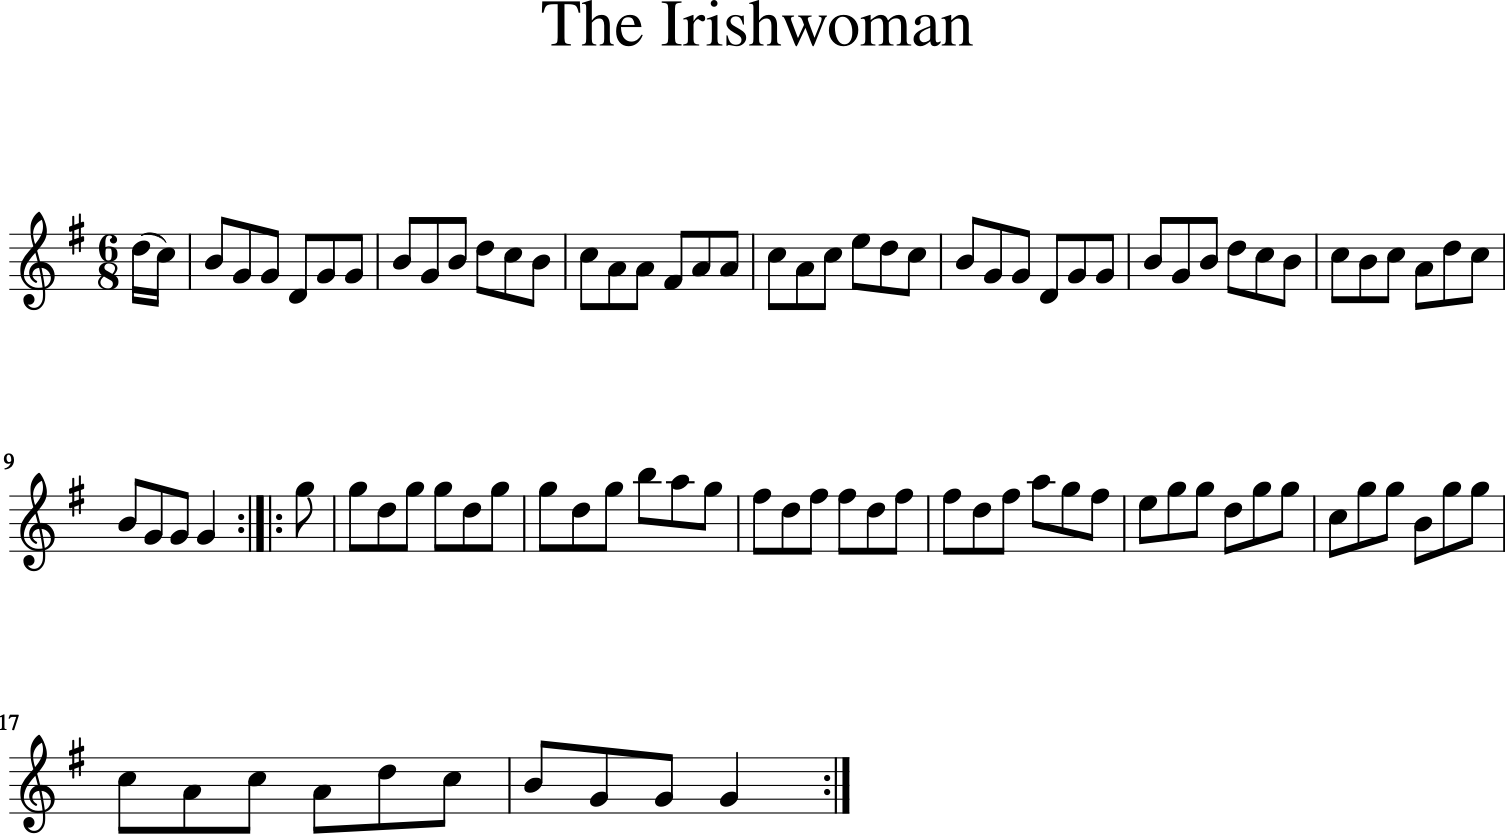

In [9]:
score.show()

## The Piper's Picnic

In [10]:
# You can select by title
score = oneills_opus.getScoreByTitle("The piper's picnic")

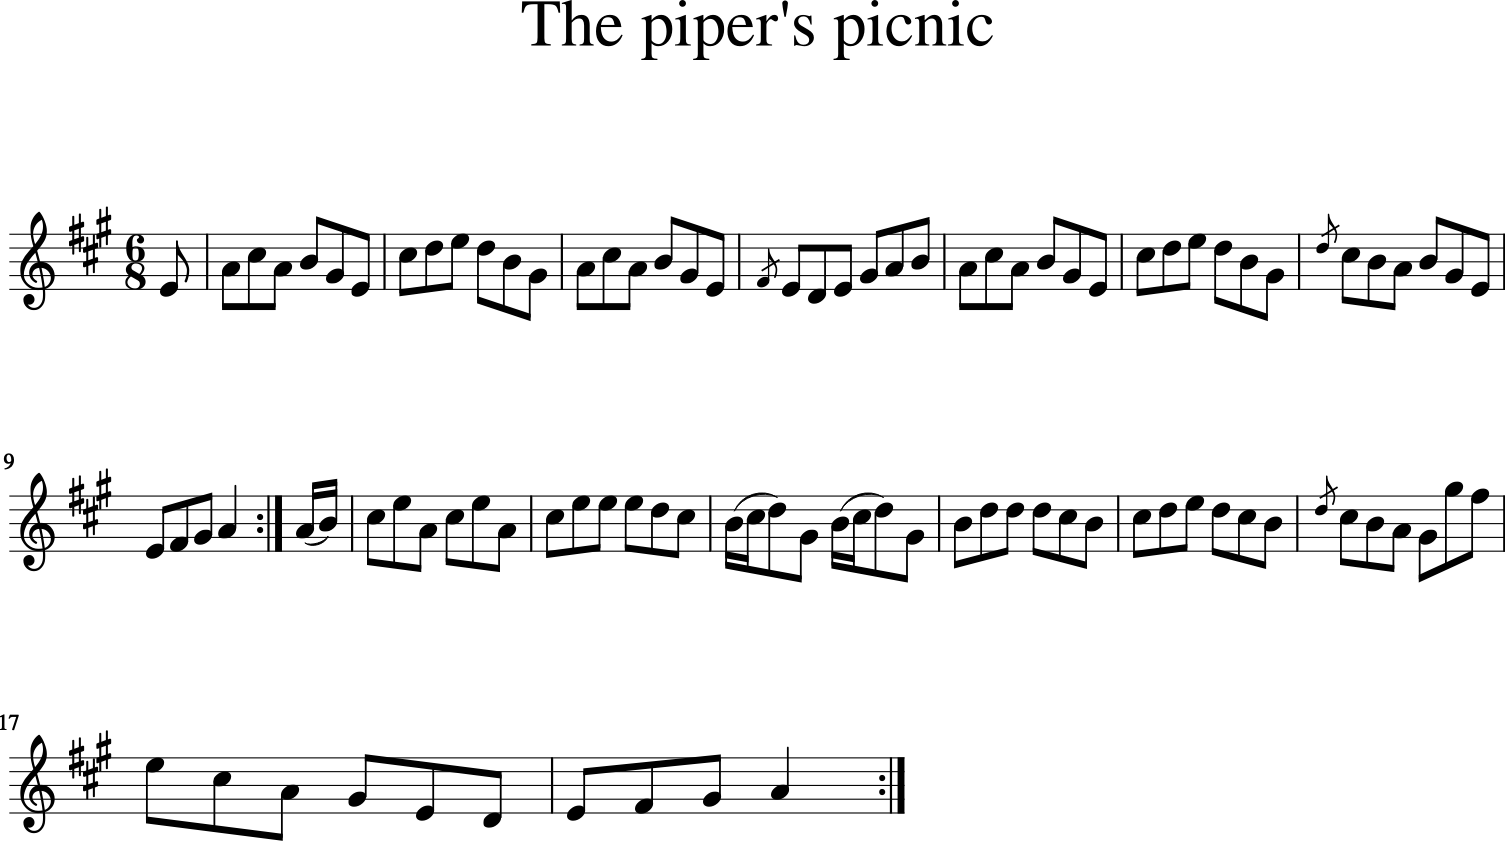

In [11]:
score.show()

Internally, music21 is storing the data as a stream of information:
* Parts contain
    * Measures which contain
        * Notes
        * and other stuff

In [12]:
score.show('text')

{0.0} <music21.metadata.Metadata object at 0x7fba288b2400>
{0.0} <music21.stream.Part 0x7fba288b2550>
    {0.0} <music21.stream.Measure 0 offset=0.0>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.key.Key of A major>
        {0.0} <music21.meter.TimeSignature 6/8>
        {0.0} <music21.note.Note E>
    {0.5} <music21.stream.Measure 1 offset=0.5>
        {0.0} <music21.note.Note A>
        {0.5} <music21.note.Note C#>
        {1.0} <music21.note.Note A>
        {1.5} <music21.note.Note B>
        {2.0} <music21.note.Note G#>
        {2.5} <music21.note.Note E>
    {3.5} <music21.stream.Measure 2 offset=3.5>
        {0.0} <music21.note.Note C#>
        {0.5} <music21.note.Note D>
        {1.0} <music21.note.Note E>
        {1.5} <music21.note.Note D>
        {2.0} <music21.note.Note B>
        {2.5} <music21.note.Note G#>
    {6.5} <music21.stream.Measure 3 offset=6.5>
        {0.0} <music21.note.Note A>
        {0.5} <music21.note.Note C#>
        {1.0} <music21.note.No

## Extracting metadata

Here's what The Piper's Picnic looks like in the raw dataset

```
X:2
T:The piper's picnic
O:Ireland
B:Francis O'Neill: "The Dance Music of Ireland" (1907) no. 2
R:Double jig
Z:Transcribed by Frank Nordberg - http://www.musicaviva.com
F:http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0002.abc
M:6/8
L:1/8
K:A
E|AcA BGE|cde dBG|\
AcA BGE|{F}EDE GAB|AcA BGE|cde dBG|{d}cBA BGE|EFG A2:|
(A/B/)|ceA ceA|cee edc|(B/c/d)G (B/c/d)G|Bdd dcB|\
cde dcB|{d}cBA Ggf|ecA GED|EFGA2:|
```

We can get (most of) that data using music21

In [13]:
meta = score.metadata
# there is only one part to each jig so index 0 works
first_measure = score.parts[0].measure(0)
second_measure = score.parts[0].measure(1)

In [14]:
# for attr_name in meta.searchAttributes:
#     print(f"{attr_name}: {getattr(meta, attr_name)}")

('2',
 "The piper's picnic",
 'Ireland',
 None,
 None,
 None,
 None,
 '<music21.meter.TimeSignature 6/8>',
 0.5,
 'A major',
 None)

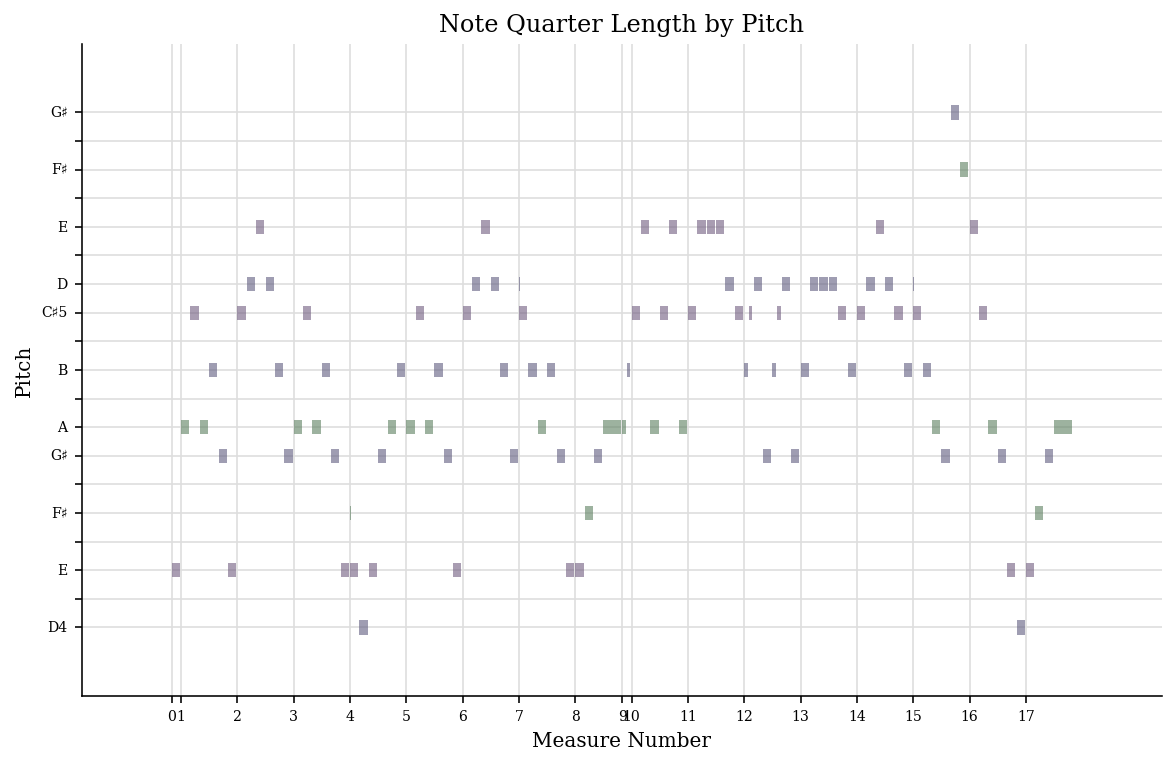

In [15]:
(
    meta.number,  # X:2
    meta.title,  # T:The piper's picnic
    meta.localeOfComposition,  # O:Ireland
    None,  # B:Francis O'Neill: "The Dance Music of Ireland" (1907) no. 2
    None,  # R:Double jig
    None,  # Z:Transcribed by Frank Nordberg - http://www.musicaviva.com
    None,  # F:http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0002.abc
    str(first_measure.timeSignature),  # M:6/8
    second_measure.offset,  # L:1/8
    str(first_measure.keySignature), # K:A
    score.plot(),  # E|AcA BGE|cde dBG|\
           # AcA BGE|{F}EDE GAB|AcA BGE|cde dBG|{d}cBA BGE|EFG A2:|
           # (A/B/)|ceA ceA|cee edc|(B/c/d)G (B/c/d)G|Bdd dcB|\
           # cde dcB|{d}cBA Ggf|ecA GED|EFGA2:|
)

# DQA

In [16]:
with open(file_path, 'r') as fh:
    # remove comments
    data_lines = [line for line in fh.readlines() if not line.startswith("%")]
    # remove leading and trailing whitespace and recombine
    data = "".join(data_lines).strip()

In [17]:
abc_strings = data.split("\n\n\n\n")

In [18]:
len(abc_strings)  # this should be 365

365

In [19]:
# Taken from: http://abcnotation.com/wiki/abc:standard:v2.1
ABC_FIELDS = {
    'A': 'area',
    'B': 'book',
    'C': 'composer',
    'D': 'discography',
    'F': 'file url',
    'G': 'group',
    'H': 'history',
    'I': 'instruction',
    'K': 'key',
    'L': 'unit note length',
    'M': 'meter',
    'm': 'macro',
    'N': 'notes',
    'O': 'origin',
    'P': 'parts',
    'Q': 'tempo',
    'R': 'rhythm',
    'r': 'remark',
    'S': 'source',
    's': 'symbol line',
    'T': 'tune title',
    'U': 'user defined',
    'V': 'voice',
    'W': 'words',
    'w': 'words',
    'X': 'reference number',
    'Z': 'transcription'
}


def merge_continuation_lines(lines: Sequence[str]):
    """Merges lines which end with \ with the next line.
    
    Args:
        lines: a list of strings to check and merge.
        
    Returns:
        lines: the list of strings which have been merged.
    """
    nr_checks = len(lines)
    idx = 0
    for _ in range(nr_checks):
        line = lines[idx]
        if line.endswith("\\"):
            line = line[:-1]  # remove trailing backslash
            try:
                lines[idx] = f"{line} {lines[idx+1]}"
                del lines[idx+1]  # del and stay on this line
            except IndexError as e:
                print(lines, line)
                raise e
        else:
            idx += 1
    return lines


def parse_abc(abc_str: str):
    """Get the required information from each tune.
    
    Extracts the metadata as defined in [1] from the string, plus the transcription
    which is assumed not to have a prefix. Assumes all metadata is stated before the
    transcription is started. Then adds everything to the transcription.
    
    Args:
        abc_str: the string containing an abc file to parse
    
    See also:
    * http://abcnotation.com/wiki/abc:standard:v2.1
    """
    lines = [line.strip() for line in abc_str.split("\n")]
    
    # if a line ends with \ then merge with subsequent line
    lines = merge_continuation_lines(lines)
    
    
    valid_field = "|".join(ABC_FIELDS)
    metadata_line_regex = re.compile(f"^({valid_field}):")
     
    _, metadata_end_idx = min(
        (val, idx)
        for (idx, val)
        in enumerate([bool(metadata_line_regex.match(line)) for line in lines])
    )
    
    out_dict = {}
    for line in lines[:metadata_end_idx]:
        meta_key, value = line.split(":", 1)
        field_name = ABC_FIELDS[meta_key]
        if field_name in out_dict:
            concat_fields = ("tune title", "words")
            if field_name not in concat_fields:
                msg = (
                    f"Tried to add {(field_name, value)} to {out_dict}."
                    f"\nLines: {lines}"
                )
                raise ValueError(msg)
            else:
                out_dict[field_name] = f"{out_dict[field_name]} --- {line}"
        out_dict[field_name] = value
    
    transcription_label = "tune"
    for line in lines[metadata_end_idx:]:
        if line.upper().startswith("W:"):
            if "words" not in out_dict:
                out_dict["words"] = line
            else:
                out_dict["words"] = f"{out_dict['words']} --- {line}"
        elif transcription_label not in out_dict:
            out_dict[transcription_label] = line
        else:
            out_dict[transcription_label] = f"{out_dict[transcription_label]} {line}"
    return out_dict

In [20]:
parsed_abc = [parse_abc(abc) for abc in abc_strings]

In [21]:
oneills_df = pd.DataFrame(parsed_abc)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

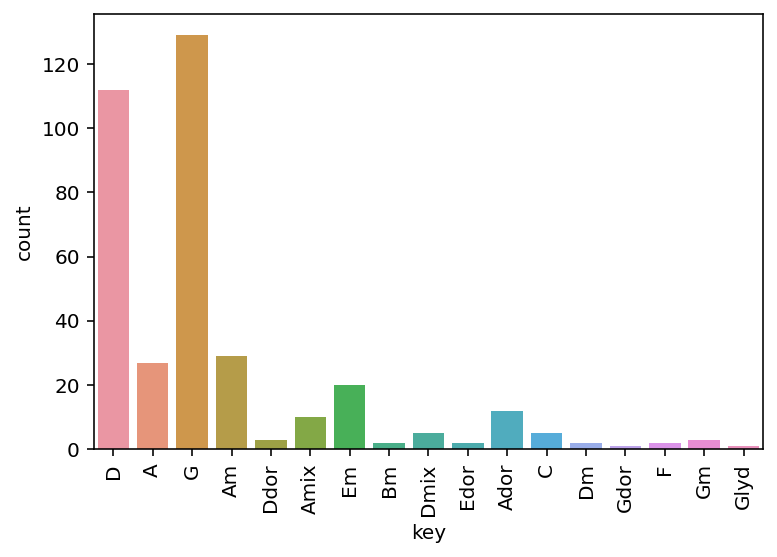

In [22]:
sns.countplot(oneills_df['key'])
plt.xticks(rotation=90)

(array([0]), <a list of 1 Text major ticklabel objects>)

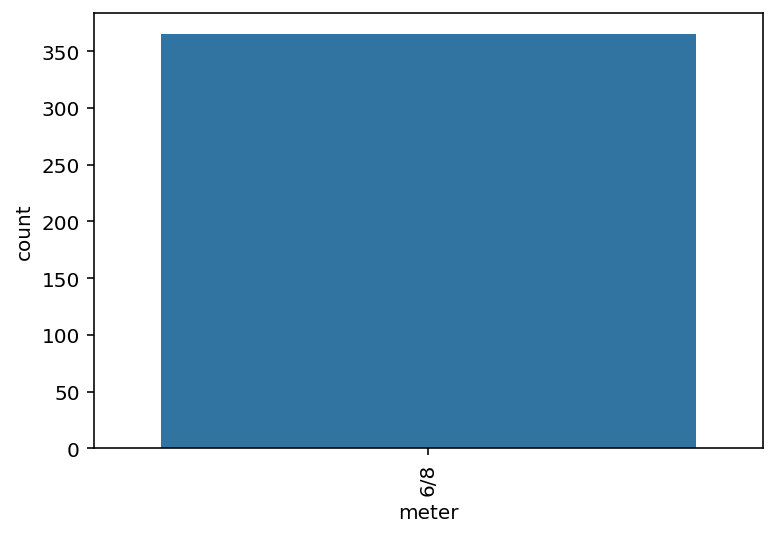

In [23]:
sns.countplot(oneills_df['meter'])
plt.xticks(rotation=90)

## Extra: music21 built-in plots

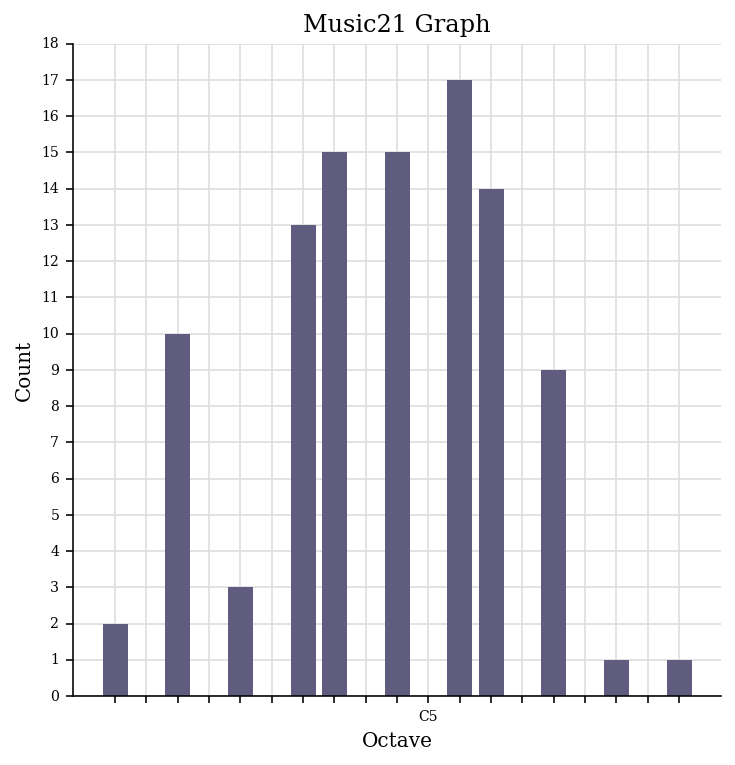

In [24]:
score.plot('histogram', 'octave', xHideUnused=False)

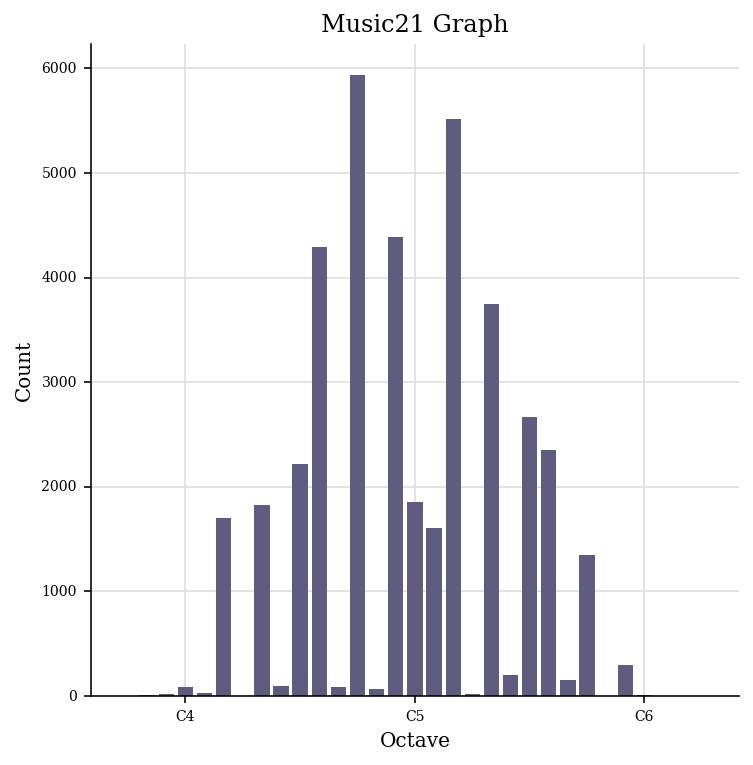

In [25]:
oneills_opus.plot('histogram', 'octave')

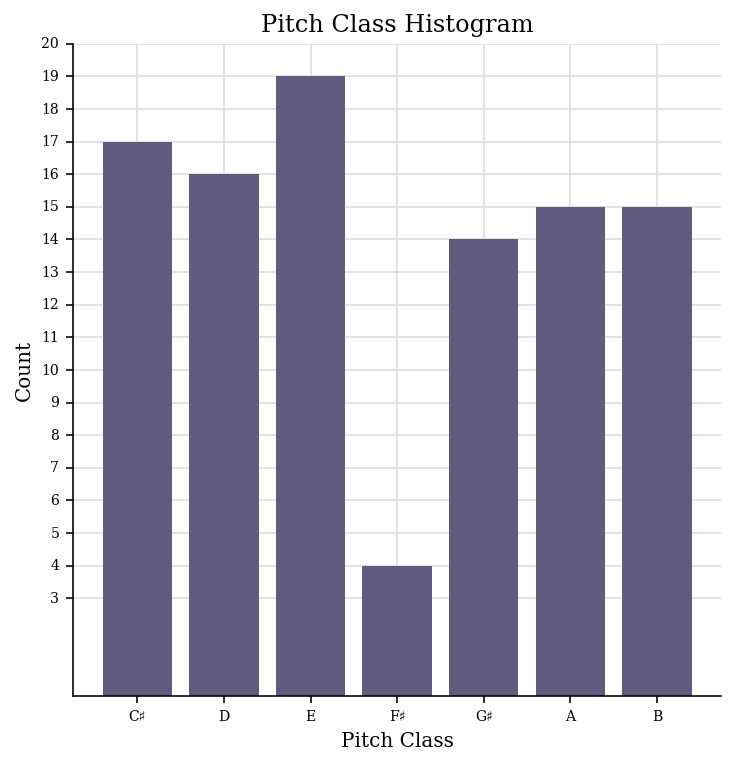

In [26]:
score.plot('histogram', 'pitchClass')

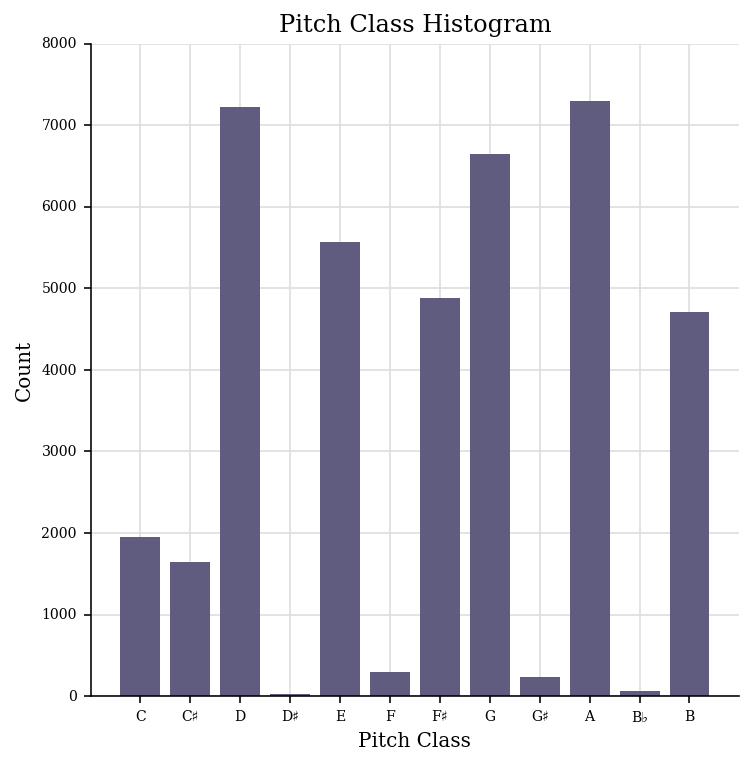

In [27]:
oneills_opus.plot('histogram', 'pitchClass')

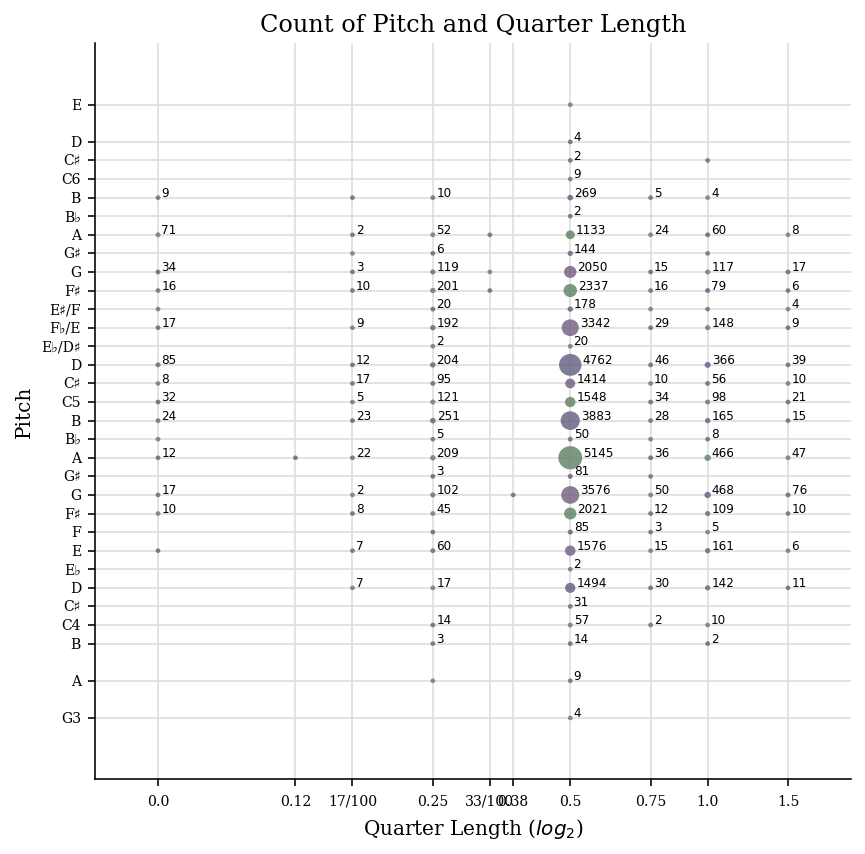

In [28]:
oneills_opus.plot('scatterweighted', 'pitch', 'quarterLength')

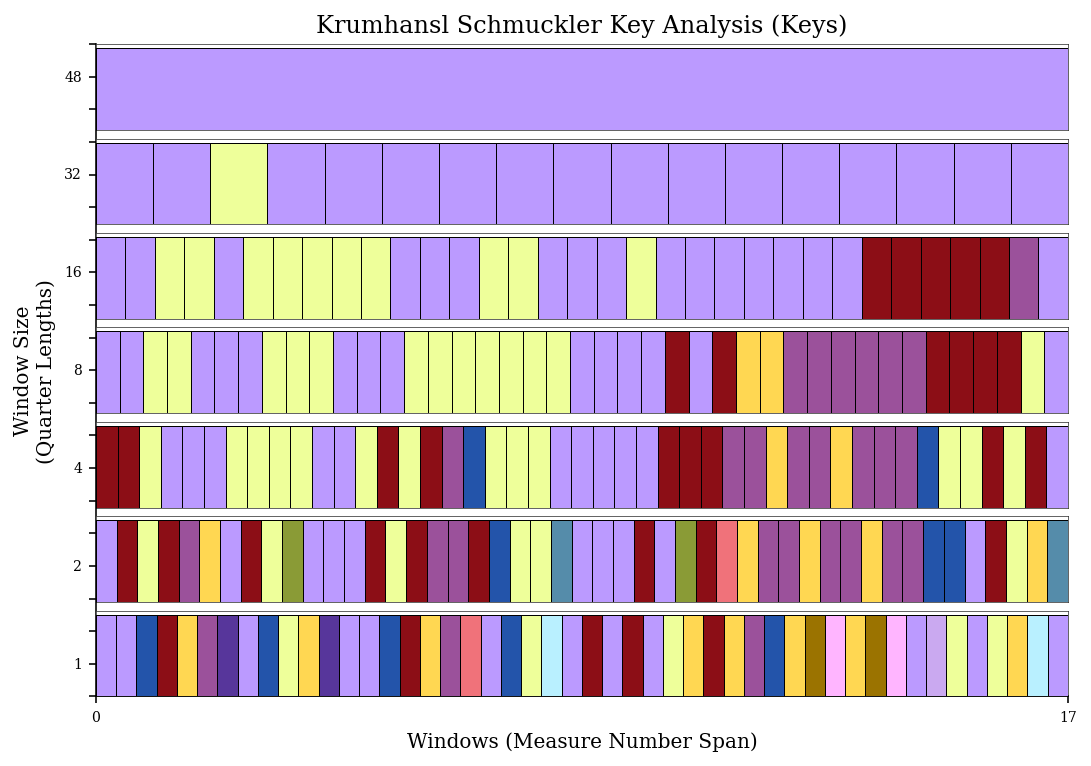

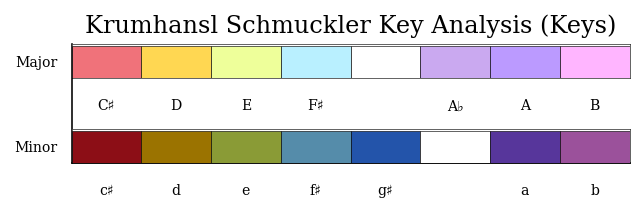

In [29]:
p = music21.graph.plot.WindowedKey(score)
p.run()